In [1]:
from PIL import Image
import requests
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
import time

import torch
import torch.nn as nn
import torchvision.transforms as T
from torchvision.models import resnet50
torch.set_grad_enabled(False)

# Define DETR

In [2]:
class DETRdemo(nn.Module):
    """
    Demo implementation of DETR in minimal number of lines, with the following differences with respect to DETR in the paper:
    - learned positional encoding (instead of sine)
    - positional encoding is passed at input (instead of attention)
    - fc bbox predictor (instead of MLP)

    The model achieves ~40 AP on COCO val5k.
    Only batch size 1 supported.
    """
    def __init__(self, num_classes, hidden_dim=256, nheads=8, num_encoder_layers=6, num_decoder_layers=6):
        super().__init__()

        # create ResNet-50 backbone
        # backbone is used for creating feature map (does not need fully connected layer)
        self.backbone = resnet50()
        del self.backbone.fc

        # create conversion layer
        # after deleting fc-layer from ResNet-50, input size 224x224 -> output size (None, 7, 7, 2048)
        # 256 -> dimension of input tokens of transformer
        self.conv = nn.Conv2d(2048, hidden_dim, kernel_size=1)

        # create a default PyTorch transformer
        self.transformer = nn.Transformer(hidden_dim, nheads, num_encoder_layers, num_decoder_layers)

        # prediction heads, one extra class for predicting non-empty slots (background detection)
        # note that in baseline DETR linear_bbox layer is 3-layer MLP
        self.linear_class = nn.Linear(hidden_dim, num_classes + 1)
        self.linear_bbox = nn.Linear(hidden_dim, 4)

        # output positional encodings (object queries)
        # gaussian distribution of 100x256 dim (100 -> sequence of transformer decoder)
        self.query_pos = nn.Parameter(torch.rand(100, hidden_dim))

        # spatial positional embeddings
        # note that in baseline DETR use sine positional encodings
        # in demo version -> set input size to 800xn (800 <= n <= 1600)
        # after resnet -> size reduce to 1/32 -> width (or height) of feature map does not exceed 50
        # sclicing to match the size of each feature map in the forward step
        self.row_embed = nn.Parameter(torch.rand(50, hidden_dim // 2))
        self.col_embed = nn.Parameter(torch.rand(50, hidden_dim // 2))

    def forward(self, inputs):
        # propagate inputs through ResNet-50 up to avg-pool layer
        x = self.backbone.conv1(inputs)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)

        x = self.backbone.layer1(x) # layer1 does not proceed downsampling
        x = self.backbone.layer2(x)
        x = self.backbone.layer3(x)
        x = self.backbone.layer4(x) # size: [None, 2048, input_height//32, input_width//32]

        # convert from 2048 to 256 feature planes for the transformer
        h = self.conv(x) # size: [None, 256, input_height//32, input_width//32]

        # construct positional encodings
        H, W = h.shape[-2:] # width and height of feature map created by backbone + conv

        # by concatenating the positional embeddings below with input tokens (1d flattend feature map, i.e. tensor h) of transformer
        # -> input tokens without positional information will contain positional information

        # 1. slicing positional embedding corresponding to the size of the feature map
        # 2. create positional embeddings (HxWx128) containing the information of column and positional embeddings (HxWx128) containing the information of row
        # 3. concat -> match the transformer's input token dimension of 256
        # 4. 2d positional embeddings of (HxWx256) -> flatten to 1d positional embeddings of (HWx256)
        pos = torch.cat([
            self.col_embed[:W].unsqueeze(0).repeat(H, 1, 1), # (W, D) -> (1, W, D) -> (H, W, D)
            self.row_embed[:H].unsqueeze(1).repeat(1, W, 1), # (H, D) -> (H, 1, D) -> (H, W, D)
        ], dim=-1).flatten(0, 1).unsqueeze(1) # (H, W, 2D) -> (HW, 2D) -> (HW, 1, 2D)

        # propagate through the transformer
        # 1d feature sequence and positional embeddings are concatenated and use for input tokens of transformer
        # returns output token correspond to the length of object queries
        # h.flatten(2).permute(2, 0, 1): (B, C, H, W) -> (B, C, H*W) -> (H*W, B, C)
        # self.query_pos.unsqueeze(1): (N, 1, D)
        h = self.transformer(pos + 0.1 * h.flatten(2).permute(2, 0, 1), self.query_pos.unsqueeze(1)).transpose(0, 1) # (H*W, B, D) -> (B, H*W, D)

        # finally project transformer outputs to class labels and bounding boxes
        # size: (1, len of object queries, # of classes (or 4 in bboxes))
        return {'pred_logits': self.linear_class(h),
                'pred_boxes': self.linear_bbox(h).sigmoid()}

# Preprocessing (on COCO dataset)

In [3]:
# COCO classes
CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

In [4]:
# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1) # separating the input tensor into four tensors
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]

    return torch.stack(b, dim=1) # merge four tensors into one tensor


def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32) # for scaling, each coordinate is multiplied by the width and height

    return b

# Import model of pre-trained DETR

In [5]:
detr = DETRdemo(num_classes=91)
state_dict = torch.hub.load_state_dict_from_url(
    url='https://dl.fbaipublicfiles.com/detr/detr_demo-da2a99e9.pth',
    map_location='cpu',
    check_hash=True
)
detr.load_state_dict(state_dict)
detr.eval()

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
Downloading: "https://dl.fbaipublicfiles.com/detr/detr_demo-da2a99e9.pth" to /root/.cache/torch/hub/checkpoints/detr_demo-da2a99e9.pth
100%|██████████| 79.3M/79.3M [00:01<00:00, 73.9MB/s]


DETRdemo(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
        

# Object detect & visualize


In [6]:
# detect
def detect(im, model, transform):
    # mean-std normalize the inpu image (batch_size: 1)
    img = transform(im).unsqueeze(0)

    # demo model only support by default images with aspect ratio between 0.5 and 2
    # if you want to use an image outside of this range, you must rescalate the maximum size to 1333 or less
    assert img.shape[-2] <= 1600 and img.shape[-1] <= 1600, 'demo model only supports images up to 1600 pixels on each side'

    # propagate through the model
    outputs = model(img)

    # keep only predictions with 0.7+ confidence
    # softmax(-1): perform softmax on last dimension
    # [0,:,:-1]: select all predictions from the first batch and probabilities excluding the last class (background class)
    # max(-1): returns maximum value and index in the last dimension
    probas = outputs['pred_logits'].softmax(-1)[0,:,:-1]
    keep = probas.max(-1).values > 0.7 # keep: boolean tensor

    # expand boxes values between 0 and 1 to image scale
    bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)

    return probas[keep], bboxes_scaled

# visualize
def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()

    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), COLORS * 100):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15, bbox=dict(facecolor='yellow', alpha=0.5))

    plt.axis('off')
    plt.show()

Inference time:  2.787 sec


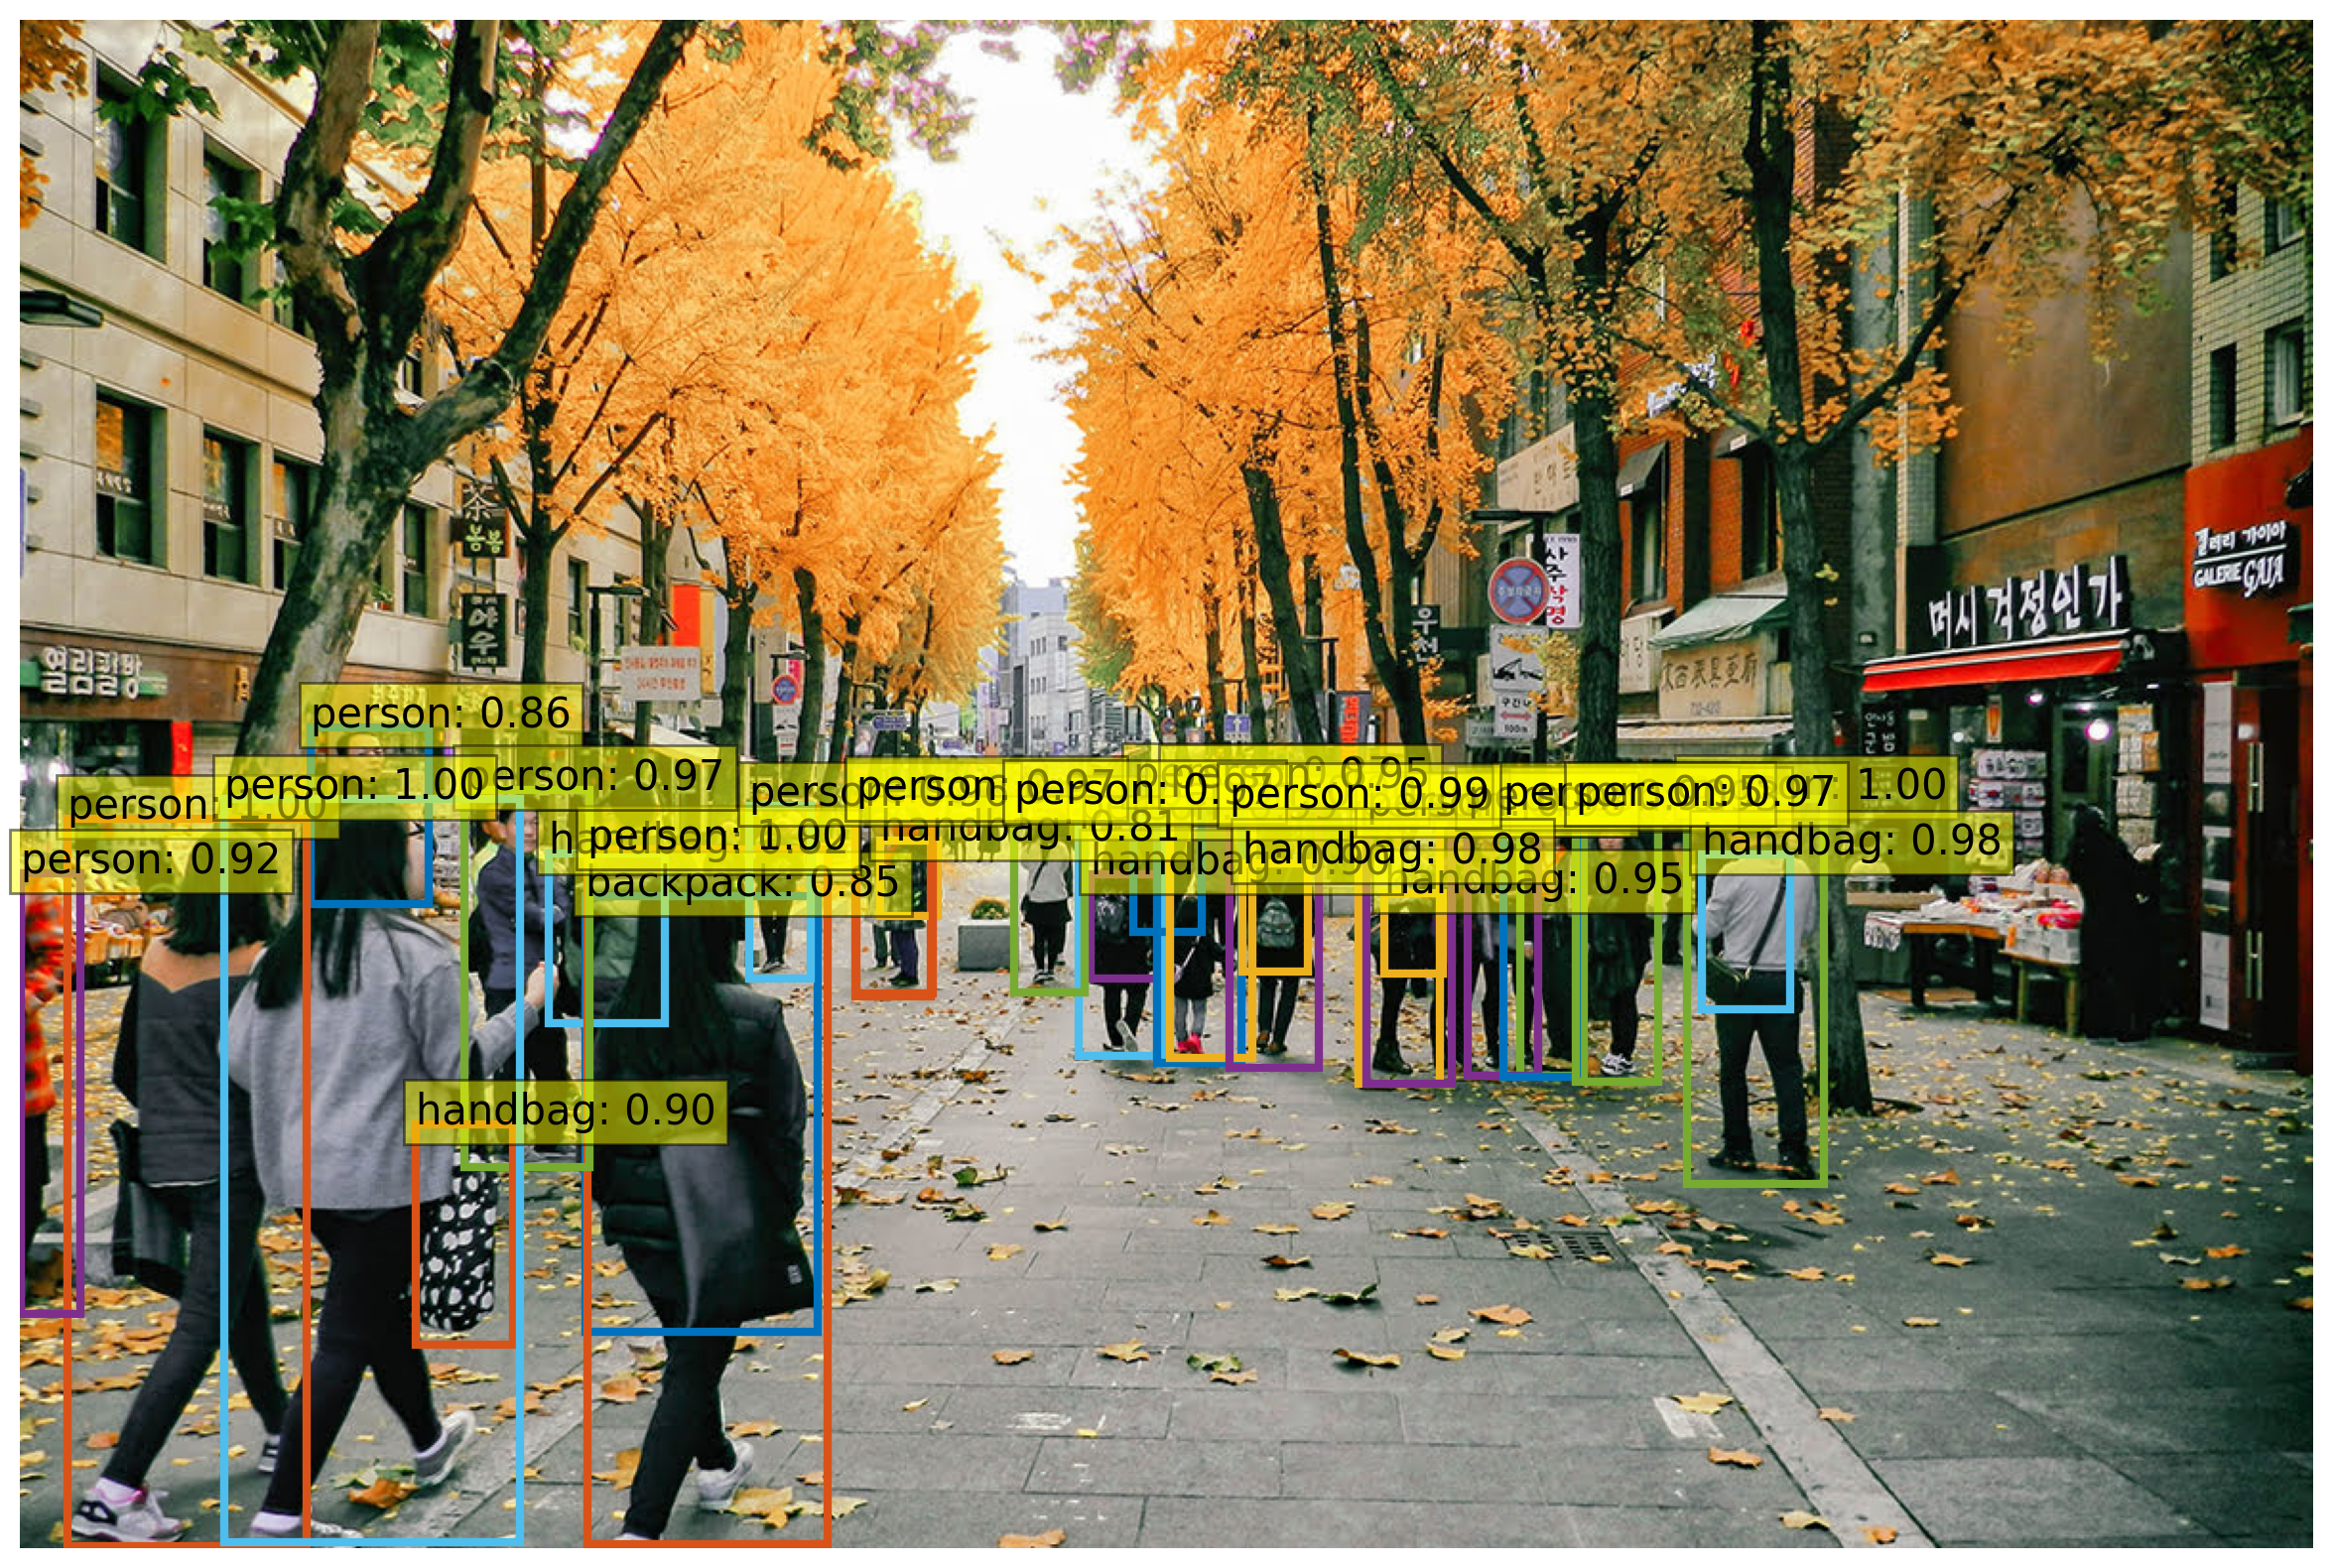

In [10]:
url = 'https://www.agoda.com/wp-content/uploads/2019/03/Seoul-attractions-Insadong.jpg'
im = Image.open(requests.get(url, stream=True).raw)

start = time.time()

scores, boxes = detect(im, detr, transform)
print("Inference time: ", round(time.time() - start, 3), 'sec')

plot_results(im, scores, boxes)